In [100]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import utils
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Red neuronal
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

# Metricas
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

In [2]:
df = utils.feature_engineering(utils.get_data())

In [25]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

pca = PCA(30) # Se explica el 75% de la varianza
scaler = MinMaxScaler(feature_range=(0,1))

X_train = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [103]:
m = Sequential()
m.add(Input(shape=(len(X_train.columns),)))
m.add(Dense(64, activation='relu'))
m.add(Dropout(0.4))
m.add(Dense(32, activation='relu'))
m.add(Dropout(0.4))
m.add(Dense(8, activation='tanh'))
m.add(Dense(1, activation='sigmoid'))

In [104]:
m.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

In [105]:
m.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 64)                1984      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 9         
Total params: 4,337
Trainable params: 4,337
Non-trainable params: 0
___________________________________________________

In [106]:
h = m.fit(X_train, y_train, epochs=300, batch_size=10, verbose=4, validation_split=0.3)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

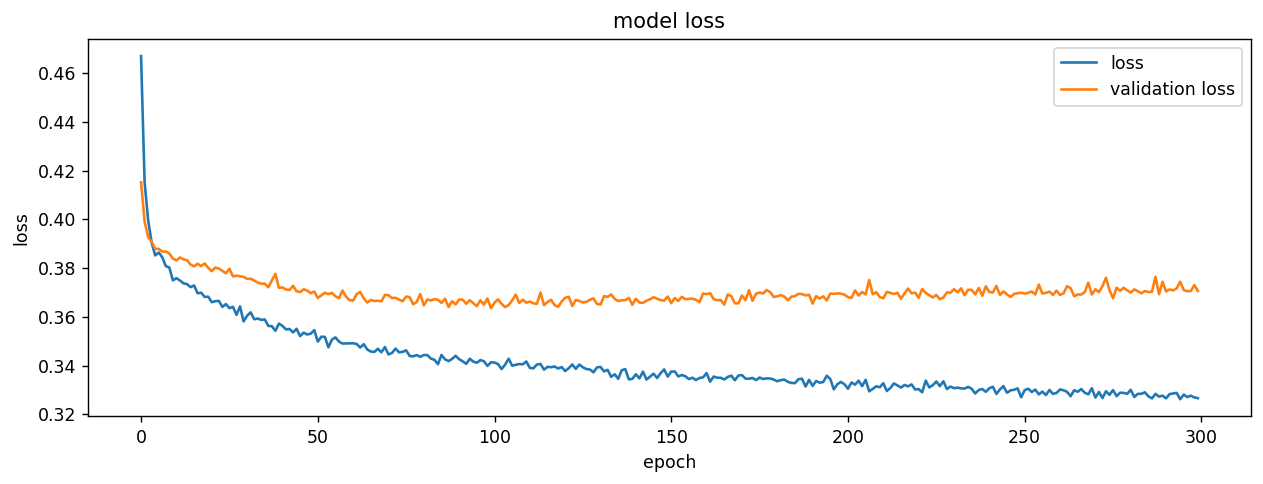

In [107]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h.history['loss'], label="loss")
plt.plot(h.history['val_loss'], label="validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

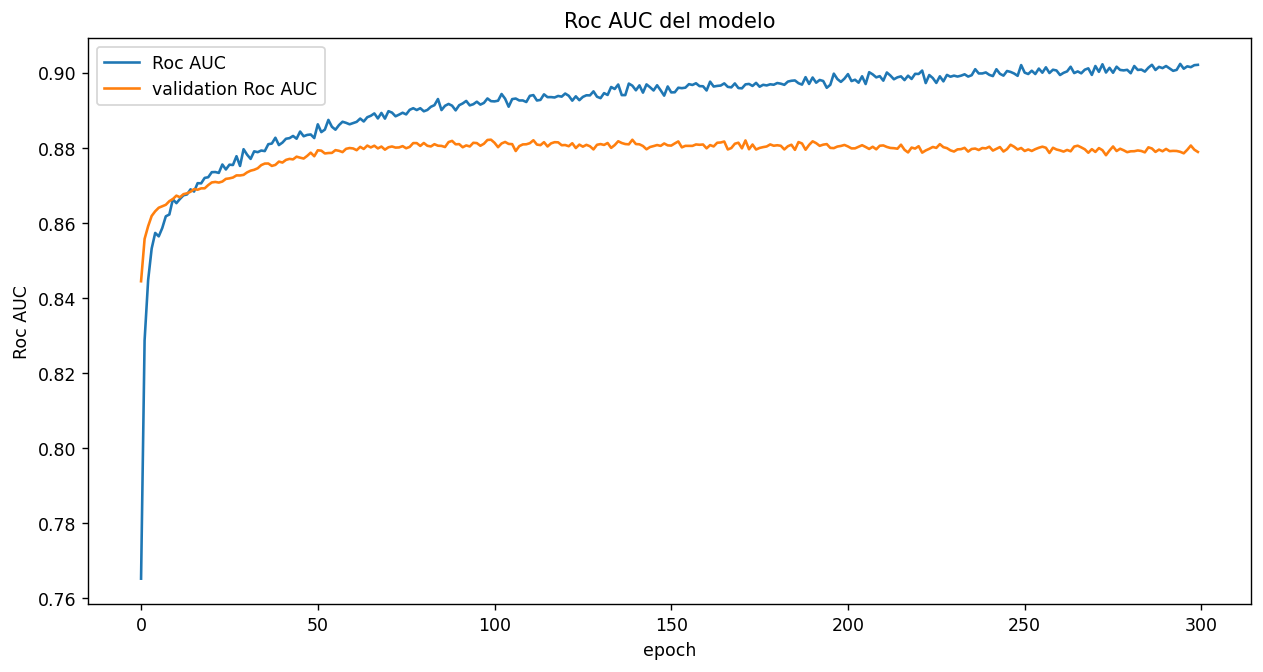

In [109]:
plt.figure(dpi=125, figsize=(12, 6))
plt.plot(h.history['auc_8'], label="Roc AUC")
plt.plot(h.history['val_auc_8'], label="validation Roc AUC")
plt.title('Roc AUC del modelo')
plt.ylabel('Roc AUC')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [117]:
print(classification_report(y_test, h.model.predict(X_test, verbose=4) > 0.5))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6186
           1       0.70      0.61      0.65      1955

    accuracy                           0.84      8141
   macro avg       0.79      0.76      0.77      8141
weighted avg       0.84      0.84      0.84      8141

